# Regresja liniowa i logistyczna

## Wstęp

![A group of people on Titanic looking at an iceberg.](titanic.png "Stable diffusion image: A photograph of Titanic crushing with an iceberg made from a matrix")


Celem laboratorium jest zapoznanie z najprostszymi narzędziami do predykcji na podstawie danych - regresją liniową i logistyczną. 
Zapoznasz się na nim z następującymi tematami:
* przygotowaniem danych, w szczególności z:
  * ładowaniem danych,
  * typami danych,
  * obsługą wartości brakujących,
  * oceną przydatności atrybutów,
  * skalowaniem wartości;
* regresją liniową, w szczególności z:
  * podziałem zbioru na część treningową i testową,
  * oceną jakości modelu,
  * walidacją skrośną,
  * wyszukiwaniem hiperparametrów;
* regresją logistyczną, w szczególności z:
  * różnymi rodzajami błędów klasyfikacji,
  * problemem przeuczenia, niedouczenia oraz metodami regularyzacji modelu.

Na pierwszych zajęciach możesz korzystać ze środowiska Google Colab i zdalnego środowiska obliczeniowego. Jeżeli interesuje Cię skonfigurowanie Pythona u siebie, to niezbędne informacje są podane w sekcji "Konfiguracja własnego komputera".

## Wykorzystywane biblioteki

Na zajęciach korzystać będziesz z kilku popularnych bibliotek do Pythona, które umożliwiają klasyfikację danych, ich wizualizację czy preprocessing. Są to:
1. [numpy](https://numpy.org/) - klasyczna bibliotek do wykonywania obliczeń macierzowych. Pozwala na efektywne przeprowadzanie obliczeń naukowych (np. na macierzach). Dobrze współgra z biblioteką pandas,
1. [pandas](https://pandas.pydata.org/) - narzędzie do analizy danych, ich strukturyzowania oraz manipulacji na nich,
1. [sklearn](https://scikit-learn.org/stable/) - narzędzie do przeprowadzania klasyfikacji, regresji, clusteringu itp. Biblioteka ta jest dość rozbudowana i pozwala także na mapowanie danych czy redukcję wymiarów. Więcej informacji znajdziesz w podanym linku,
1. [missingno](https://pypi.org/project/missingno/) - narzędzie do wizualizacji kompletności danych (brakujących wartości),
1. [seaborn](https://seaborn.pydata.org/) - kompleksowe narzędzie do wizualizacji danych jako takich. Pozwala na stworzenie bardzo szerokiej gamy wykresów w zależności od potrzeb.

Zostały tutaj pominięte pewne standardowe biblioteki jak np. os czy matplotlib.

## Konfiguracja własnego komputera

Jeżeli korzystasz z własnego komputera, to musisz zainstalować trochę więcej bibliotek (Google Colab ma je już zainstalowane). Najlepiej używać Pythona 3.9, z którym laboratorium było testowane.

### Anaconda

Jeżeli korzystasz z Anacondy (możesz uruchomić w terminalu):

In [1]:
!conda install -c conda-forge --yes pandas scikit-learn matplotlib missingno imbalanced-learn lightgbm shap

/bin/bash: line 1: conda: command not found


### venv

Jeżeli używasz zwykłego venv'a (**zdecydowanie niezalecane, szczególnie na Windowsie**):

In [2]:
!pip install --yes pandas scikit-learn matplotlib missingno imbalanced-learn lightgbm shap


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes


W przypadku własnego komputera, jeżeli instalowałeś z terminala, pamiętaj, aby zarejestrować aktualne środowisko wirtualne jako kernel (środowisko uruchomieniowe) dla Jupyter Notebooka. Wybierz go jako używany kernel w menu na górze notebooka (nazwa jak w komendzie poniżej).

In [3]:
!ipython kernel install --user --name "PSI"

Installed kernelspec PSI in /home/mateusz/.local/share/jupyter/kernels/psi


# Przygotowanie danych

## Ładowanie danych tabelarycznych

Jeżeli pracujesz na Google Colab, zacznij od przeniesienia dwóch plików CSV, które zostały dołączone do laboratorium (`titanic.csv` oraz `titanic_test.csv`), do folderu `/content`. Nie musisz ich umieszczać w `/content/sample_data` - ważne, aby znalazły się w `/content`. Jeżeli pracujesz lokalnie, to wystarczy, że pliki te będą obok tego notebooka.

Pliki te to dwa zbiory, jeden jest treningowy (czyli z etykietą klasy), a drugi tych etykiet nie posiada. Celem jest oszacowanie na podstawie dostępnych danych tabelarycznych, czy dany pasażer Titanica przeżył katastrofę (etykieta ma wtedy wartość 1), czy miał mniej szczęścia. Dokładny zestaw cech, którymi będziemy dysponować, omówimy sobie w dalszej części laboratorium.

Wczytajmy dane `titanic.csv` do zmiennej `train_data`.

In [4]:
import pandas as pd

train_data = pd.read_csv("titanic.csv")

Zobaczmy jakie dane znajdują się w naszej tabeli. Wykorzystajmy do tego metodę `info()`.

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Szczegółowy opis znaczenia kolumn znajdziesz na [pod linkiem](https://www.kaggle.com/competitions/titanic/data?select=train.csv). Zapoznaj się z akapitem **Data Dictionary**. 

## Wstępna analiza danych

W przytłaczającej większości przypadków, zanim zaczniesz robić jakąkolwiek predykcję czy analizę danych, dobrze jest zapoznać się z nimi, z ich kodowaniem i znaczeniem. Kolejnym istotnym aspektem jest typ danych. Otóż nie każdy klasyfikator nadaje się do każdego typu.

Wyświetlmy teraz kilka przykładowych rekordów z samej góry korzystając z metody `head()`.

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Jeżeli potrzebujesz szybko stwierdzić, ile dane zawierają rekordów i kolumn, pomocna okazuje się opcja `shape`:

In [7]:
train_data.shape

(891, 12)

## Dane kategoryczne

Już możemy wysnuć pierwsze wnioski i zauważyć pierwszy problem. Istnieją dwa rodzaje danych: kategoryczne (z ang. *categorical data*) oraz numeryczne (z ang. *numerical data*). Ten podział jest bardzo istotny. Dane numeryczne to żadna niespodzianka, po prostu mają swoją wartość, jak np. **Fare**, czyli opłata za rejs. Dane kategoryczne to takie, którym w większości przypadków nie można przyporządkować wartości liczbowej (wyjątkiem są dane kategoryczne uporządkowane).

Wyobraź sobie, że klasyfikujesz kolory i masz wartości RGB. Nie możesz ich zakodować jako np.: R = 0, G = 1 i B = 2. Stwierdzasz tym samym, że w jakimś sensie R < G, R < B i G < B. Nie ma powodu tak sądzić. Istnieje jednak pewien wyjątek. Spójrz na kolumnę **Sex**. Z opisu danych wiesz, że przyjmuje ona dokładnie dwie wartości kategoryczne: *Male* oraz *Female*. W takiej sytuacji wolno Ci zakodować te wartości numerycznie jako 0 i 1. Stwierdzasz tym samym, że ktoś jest **male** albo nie jest. Bez straty w ogólnej definicji problemu możesz zakodować odwrotnie i stwierdzić, że ktoś jest **female** albo nie jest.

Wykonaj poniższy kod. Zauważ, że takie zakodowanie cechy miało wpływ na zużycie pamięci (`memory usage`). Jak myślisz, dlaczego?

In [8]:
from pandas import Categorical

train_data["Sex"] = Categorical(train_data["Sex"]).codes
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int8   
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), int8(1), object(4)
memory usage: 77.6+ KB


Posiadamy jeszcze jedną kolumnę, która może być dla nas istotna, a zawiera nie dwie, tylko trzy wartości kategoryczne. Jest to kolumna **Embarked**, oznaczająca port, w którym dany pasażer wsiadł. Jak już ustaliliśmy, nie można jej zakodować jako np. 0, 1, 2. Można natomiast usunąć kolumnę **Embarked** i stworzyć trzy nowe, zawierające tylko wartości 0 oraz 1, gdzie 1 oznacza, że pasażer wsiadł w danym porcie. Taką technikę nazywamy z ang. *one-hot encoding*.

Zastanów się, co nam daje ta technika, z punktu widzenia wykonywania obliczeń na danych?

In [9]:
from pandas import get_dummies

train_data = get_dummies(data=train_data, columns=["Embarked"])
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1


## Wartości brakujące

Niestety, ale nasze dane trenujące nie są kompletne. Możesz się o tym przekonać, wykonując poniższy kod:

In [10]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked_C       0
Embarked_Q       0
Embarked_S       0
dtype: int64

Możesz zauważyć, że w naszych danych 177 rekordów (z 891) posiada brakującą informację na temat wieku. Z kolei w 687 rekordach brakuje informacji o numerze kabiny. Biblioteką, która pozwala na zwizualizowanie tych braków, jest *missingno*.

**Zadanie 1 (0.5p.)**

Stwórz wykres słupkowy brakujących danych zawartych w `train_data` wykorzystując *missingno*.

<AxesSubplot: >

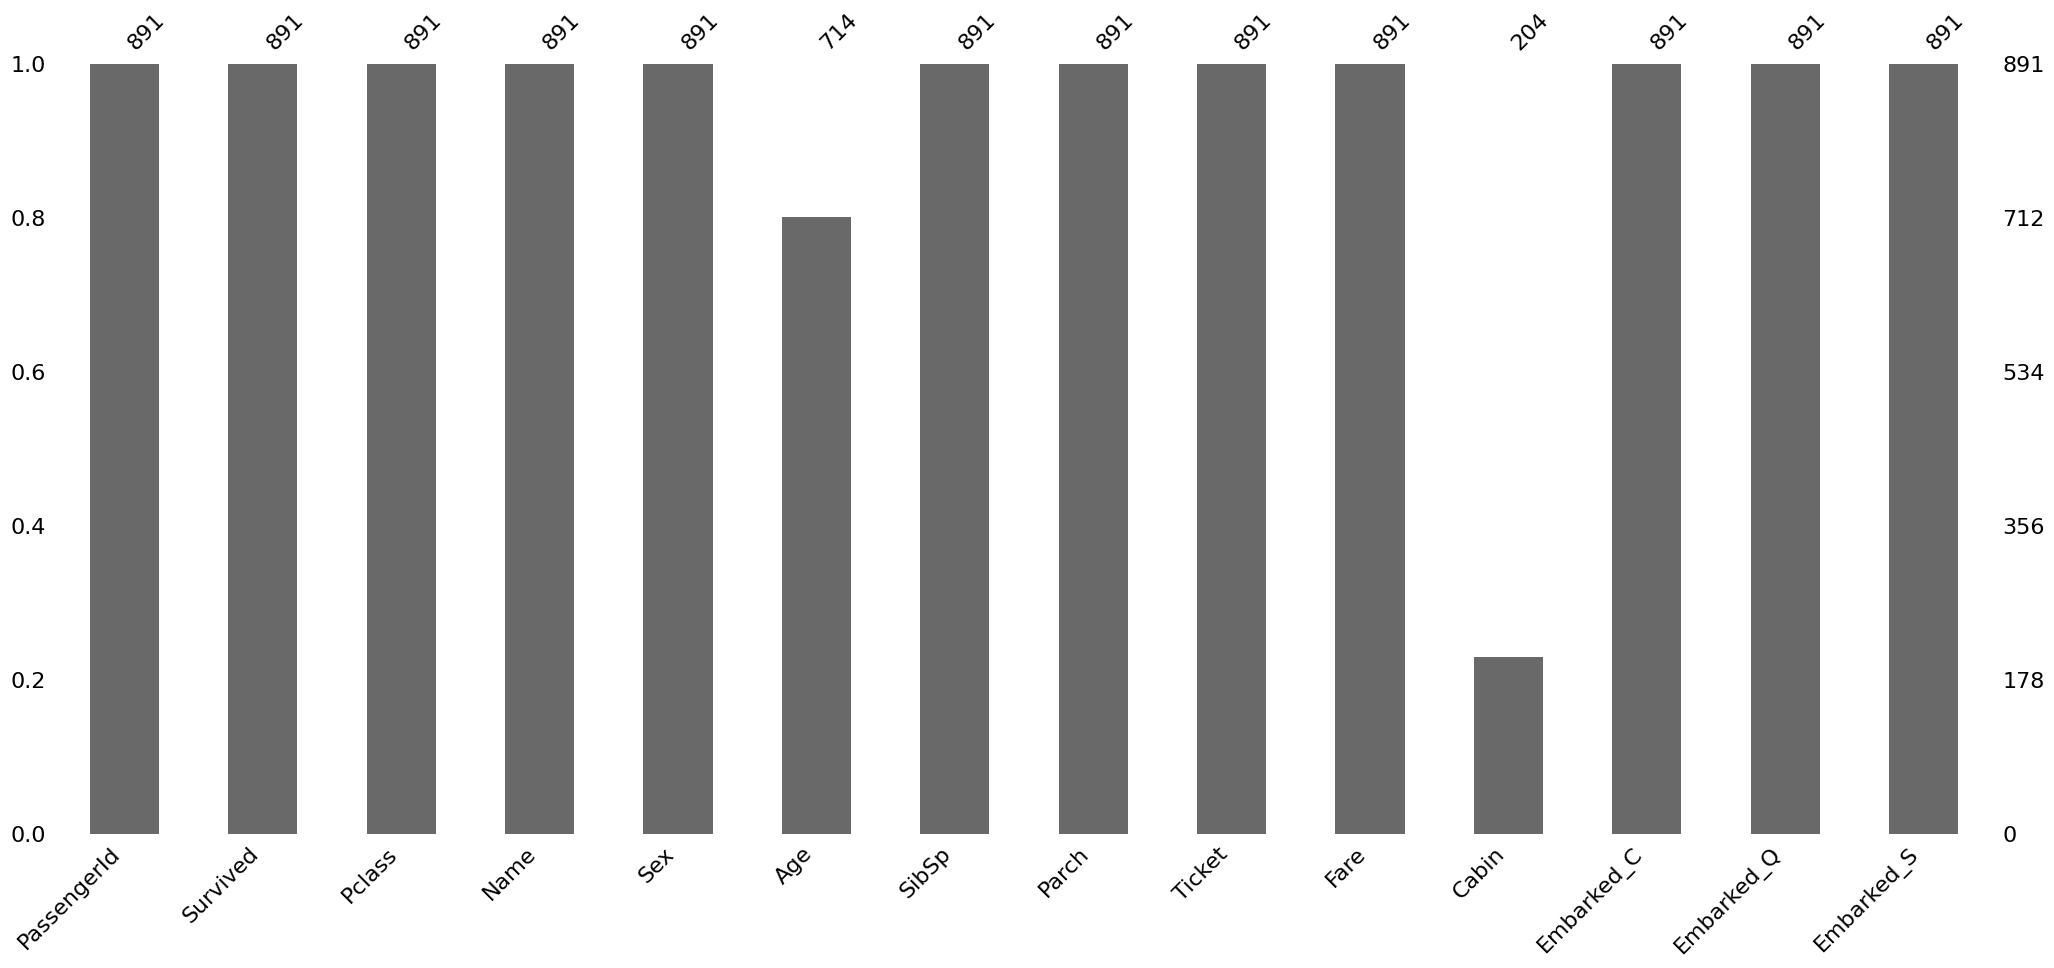

In [11]:
import missingno as miss

miss.bar(train_data)

Skupmy się na kolumnie **Cabin**. Nie będzie nam potrzebna w dalszej predykcji. Po pierwsze są to wartości kategoryczne i jako takie niewiele wnoszą (i tak dysponujemy takimi danymi jak klasa czy opłata). Możemy więc usunąć całą kolumnę.

In [12]:
train_data = train_data.drop(columns="Cabin")

Z wiekiem (kolumna **Age**) problem jest większy. Danych brakuje w wielu rekordach, ale nie na tyle wielu, aby tę kolumnę usunąć. Co więcej, może ona być istotna w dalszej predykcji. Musimy się więc zastanowić nad strategią rozwiązania tego problemu. 

Z brakującymi danymi możemy sobie radzić w sposób następujący:
1. Usunąć kolumnę, która zawiera brakujące wartości,
1. Usunąć wiersze, w których brakuje wartości,
1. Zastąpić brakujące wartości innymi, np. średnią z kolumny, medianą albo wielkością stałą,
1. Przewidzieć brakujące wartości wykorzystując odpowiedni model uczenia maszynowego.

Ustaliliśmy przed chwilą, że w tym przypadku nie interesują nas rozwiązania 1 oraz 2. Spróbujmy rozwiązania numer 3.

**Zadanie 2 (0.5p.)**

Zastąp brakujące dane w kolumnie **Age** średnią z tej kolumny. 

**UWAGA** - jeśli wykonujesz operację tego rodzaju, to warto zostawić oryginalne dane, np. żeby poeksperymentować z różnymi metodami uzupełniania danych. Tak też należy zrobić w tym przypadku.

In [13]:
data2 = train_data.copy(deep=True)

mean = round(data2["Age"].mean())
data2["Age"] = data2["Age"].fillna(mean)

Docelowo będziemy chcieli zastosować strategię numer 4, gdyż dysponujemy odpowiednią liczbą przykładów uczących. Zajmiemy się tym w następnej części laboratorium. 

## Korelacja atrybutów

Analizując pozostałe kolumny, można dojść do wniosku, że imię nie powinno mieć znaczenia w predykcji. Numer biletu to dane kategoryczne, których nie zakodujemy numerycznie. Najzwyczajniej nie miałoby sensu generowanie 891 nowych kolumn. W ramach laboratorium dotyczącego przetwarzania języka dowiemy się, jak można tego rodzaju dane wykorzystać, ale w tym laboratorium po prostu je pominiemy.

**Zadanie 3 (0.5p.)**

Usuń kolumny **Name** oraz **Ticket** ze zbioru trenującego.

In [14]:
train_data = train_data.drop(columns=["Name", "Ticket"])

In [15]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,22.0,1,0,7.2500,0,0,1
1,2,1,1,0,38.0,1,0,71.2833,1,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,0,1
3,4,1,1,0,35.0,1,0,53.1000,0,0,1
4,5,0,3,1,35.0,0,0,8.0500,0,0,1


Ale jest jeszcze coś. Pomoże nam w tym macierz korelacji. Wykonaj poniższy kod.

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.036847,-0.057527,-0.001652,0.012658,-0.001205,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,0.257307,0.168240,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,-0.549500,-0.243292,0.221009,0.081720
Sex,0.042939,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,-0.182333,-0.082853,-0.074115,0.125722
Age,0.036847,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067,0.036261,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.159651,-0.059528,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.216225,-0.011069,-0.081228,0.063036
Fare,0.012658,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,1.000000,0.269335,-0.117216,-0.166603
Embarked_C,-0.001205,0.168240,-0.243292,-0.082853,0.036261,-0.059528,-0.011069,0.269335,1.000000,-0.148258,-0.778359
Embarked_Q,-0.033606,0.003650,0.221009,-0.074115,-0.022405,-0.026354,-0.081228,-0.117216,-0.148258,1.000000,-0.496624


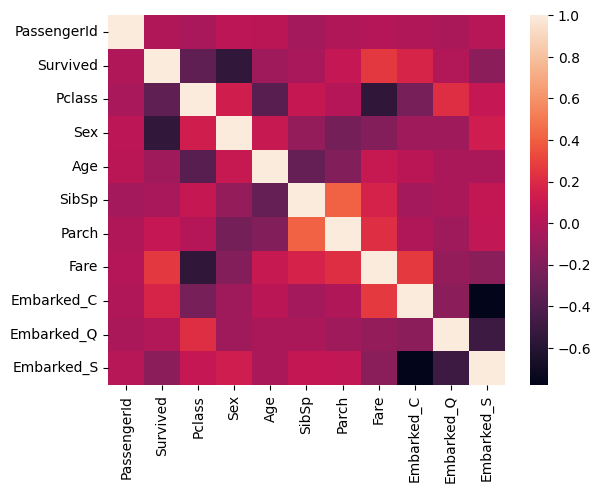

In [16]:
from seaborn import heatmap

heatmap(train_data.corr())
train_data.corr()

To, co widzisz to macierz korelacji (pod spodem reprezentacja graficzna). Współczynniki w macierzy korelacji to tzw. współczynniki korelacji [Pearsona](https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/). Współczynnik ten oznaczamy jako *r* i przyjmuje on wartości z przedziału [-1, 1], gdzie -1 oznacza silną korelację ujemną (wysokim wartościom jednej cechy odpowiadają niskie drugiej lub odwrotnie), a 1 oznacza silną korelację dodatnią (wysokim wartościom jednej cechy odpowiadają wysokie wartości drugiej i odwrotnie). Taka macierz pozwala nam zweryfikować, czy w naszym zbiorze danych nie ma redundancji. Bardzo często korzystamy wówczas z wartości bezwzględnej *r*, gdyż interesuje nas fakt czy korelacja w ogóle jest, czy jej nie ma.

W tworzeniu modelu predykcji, najbardziej pożądane cechy posiadają następujące własności:
- mają niski współczynnik korelacji z innymi cechami (chcemy, aby kolumny niosły jak najwięcej różnych informacji)
- wysoki współczynnik korelacji z klasą, którą chcemy przewidywać (chcemy, aby kolumny z cechami mówiły jak najwięcej o klasie, którą będziemy przewidywać)

Analizując powyższe macierze, zauważyć można, że kolumna **PassengerId** nie jest silnie skorelowana w zasadzie z niczym, a w szczególności z **Age** oraz **Survived** (która to kolumna będzie nas później interesować).

In [17]:
train_data = train_data.drop(columns="PassengerId")

Mamy jeszcze problem. Przed zakodowaniem kolumny **Embarked** nie sprawdziliśmy, czy przypadkiem nie brakowało tam jakichś wartości. Jeżeli brakowało, to będziemy mieli wiersze, gdzie w każdej nowej kolumnie **Embarked** (C, Q, S) będzie zero.

**Zadanie 4 (0.5p.)**

Sprawdź, czy ma miejsce sytuacja, w której w danym wierszu **Embarked_C == Embarked_Q == Embarked_S == 0**. Jeżeli liczba takich rekordów jest mała - usuń je ze zbioru `train_data`.

In [18]:
idxs = train_data[(train_data["Embarked_C"] == train_data["Embarked_Q"]) & \
                  (train_data["Embarked_Q"] == train_data["Embarked_S"]) & \
                  (train_data["Embarked_S"] == 0)].index
print(idxs)
train_data = train_data.drop(idxs)

Int64Index([61, 829], dtype='int64')


## Skalowanie wartości

Ostatnim elementem preprocessingu danych jest ich skalowanie. Zastanów się, co by się stało, gdyby wartości w jednej kolumnie wynosiły np. `[10000, 100000]`, a w drugiej `[1, 10]`. Często takie zjawisko może powodować zaburzenia w trenowaniu modelu oraz jakości predykcji. Wszakże każdy algorytm w końcu sprowadza się do dodawania, mnożenia, dzielenia itp. Więcej informacji na temat tego, dlaczego skalowanie jest aż tak istotne, możesz znaleźć [tu](https://analyticsindiamag.com/why-data-scaling-is-important-in-machine-learning-how-to-effectively-do-it/).

Wykonajmy poniższy kod. Skaluje on wartości numeryczne z kolumn do przedziału `[0, 1]` z wykorzystaniem `MinMaxScaler`. Skalowanie odbywa się osobno dla każdej cechy.

**Uwaga**: zawsze zapisuj nazwy kolumn, gdyż funkcja ta zwraca tablicę numpy, pozbawiona jest informacji o nazwach atrybutów. Zauważ też, że operujemy tylko na danych treningowych (w kontekście kolumny **Survived**).

In [19]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

data_columns = train_data.columns
scaler = MinMaxScaler()
train_data = DataFrame(scaler.fit_transform(train_data))
train_data.columns = data_columns
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0.0,1.0,1.0,0.271174,0.125,0.0,0.014151,0.0,0.0,1.0
1,1.0,0.0,0.0,0.472229,0.125,0.0,0.139136,1.0,0.0,0.0
2,1.0,1.0,0.0,0.321438,0.000,0.0,0.015469,0.0,0.0,1.0
3,1.0,0.0,0.0,0.434531,0.125,0.0,0.103644,0.0,0.0,1.0
4,0.0,1.0,1.0,0.434531,0.000,0.0,0.015713,0.0,0.0,1.0


Ten podrozdział pokrył kluczowe aspekty przygotowania danych. Ale jest jeszcze jedna rzecz, którą trzeba wiedzieć. Czasami optymalnym rozwiązaniem jest generowanie zupełnie nowych atrybutów (w oparciu o te istniejące) i używanie tych nowych atrybutów w procesie trenowania modelu. Takim algorytmem jest np. [YAGGA](https://docs.rapidminer.com/8.0/studio/operators/modeling/optimization/feature_generation/optimize_by_generation_yagga2.html) (wykorzystywana w innym popularnym środowisku do uczenia maszynowego, jakim jest RapidMinerStudio). Przy czym dla powyższego przykładu wykorzystanie tego algorytmu byłoby nieuzasadnione. Poza tym biblioteka sklearn nie posiada tego algorytmu.

# Regresja liniowa

Regresja liniowa jest jednym z najprostszych modeli predykcyjnych. Nadaje się ona do predykcji danych numerycznych, a więc w naszym przypadku np. do predykcji danych w kolumnie **Age**. Prosta regresja liniowa, dla 1 zmiennej, wyraża się wzorem:

$$
y = ax + b,
$$

gdzie *y* to zmienna zależna, *x* to zmienna niezależna, a współczynniki *a* i *b* liczone są wg wzorów opisanych [tu](https://www.vedantu.com/formula/linear-regression-formula), bez wątpienia znanych Ci z algebry liniowej.

Pewnym rozwinięciem regresji liniowej jest Wielokrotna Regresja Liniowa (*Multiple Linear Regression*, *MLR*), która pozwala na wykorzystanie więcej niż jednej cechy do predykcji wartości. Stanowi ona de facto kombinację liniową pojedynczych cech. Więcej o tym mechanizmie możesz przeczytać [tu](https://rankia.pl/analizy-gieldowe/co-to-jest-wielokrotna-regresja-liniowa-mlr/).

Przygotujmy się do naszej pierwszej predykcji. Z całości zbioru `train_data` wyodrębnimy te przykłady, w których nie brakuje danych z kolumny **Age**.

In [20]:
train_data_linear = train_data.dropna(inplace=False, subset=["Age"])

## Podział na zbiór treningowy i testowy

Nasz zbiór `train_data_linear` podzielmy na dwa podzbiory: trenujący (75%) i testowy (25%). Trenujący pozwoli nam utworzyć model regresji liniowej, natomiast testowy - oszacować jej jakość. W tym momencie do predykcji wieku użyjemy tylko cechy **SibSp** (dla przykładu), będzie to więc klasyczna regresja liniowa. Pamiętaj, że wyniki uzyskiwane przez model na danych treningowych nie są wiarygodne. Konieczne jest sprawdzenie, jak model radzi sobie na danych testowych.

**Uwaga**: W eksperymentach ustalamy na sztywno wartość parametru `random_state`. [Doczytaj](https://scikit-learn.org/stable/glossary.html#term-random_state), dlaczego wykorzystywany jest ten parametr i co się dzieje, gdy jest on równy zero.

In [21]:
from sklearn.model_selection import train_test_split

x = train_data_linear["SibSp"]
y = train_data_linear["Age"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=0, shuffle=True
)
x_train = x_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

## Trening modelu regresji

Na poniższym przykładzie możesz zobaczyć, jak trenujemy model oraz jak wygląda jego reprezentacja graficzna.

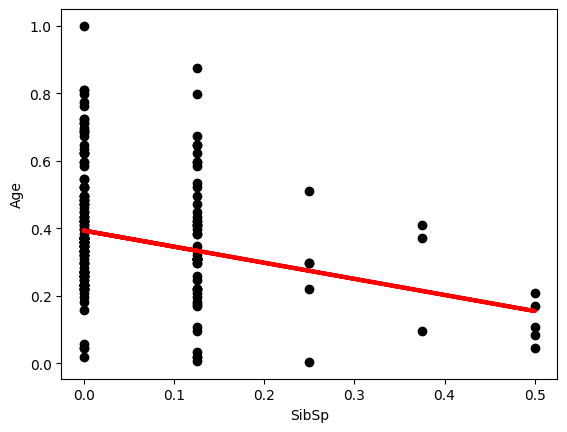

In [22]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

model = LinearRegression()
model.fit(x_train, y_train)
predict = model.predict(x_test)

plt.scatter(x_test, y_test, color="black")
plt.xlabel("SibSp")
plt.ylabel("Age")
plt.plot(x_test, predict, color="red", linewidth=3)

## Ocena jakości modelu

Pytanie: skąd wiemy, czy nasz model działa dobrze, czy też źle? W regresji liniowej mamy do tego dwa podstawowe wskaźniki: Współczynnik determinacji (`r2_score`), który pokazuje, jak silna jest korelacja pomiędzy modelem, a próbą (im bliżej 1, tym lepiej), oraz błąd średniokwadratowy (**MSE** - *mean square error*), który pokazuje błąd średniokwadratowy naszego modelu (im bliżej 0, tym lepiej). Wykonaj poniższy kod, aby obliczyć oba te współczynniki dla wytrenowanego modelu.

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predict)
MSE = mean_squared_error(y_test, predict)
print(r2)
print(MSE)

0.0683715756953468
0.03424820189222955


Nasza wartość MSE jest przyzwoita, stosunkowo blisko zera. Zauważ natomiast, że współczynnik determinacji jest także bliski zeru. Czy to źle? Cóż, w naszym przypadku istotniejszy jest MSE. To, że nasz model przewiduje raz wiek zbyt duży, a raz zbyt mały, nie jest dla nas aż tak istotne, gdyż różnica od wieku prawdziwego jest niewielka. Pamiętaj jednak, że w przypadku wartości MSE istotna jest też skala (przedział) danych, które przewidujemy. Powyższa wartość MSE nie byłaby aż tak korzystna, gdyby przeskalowana wartość **AGE** wahała się np. w przedziale $[0, 0.03]$. Tak jednak nie jest.

In [24]:
print(min(y_test))
print(max(y_test))

0.0041467705453631576
1.0


["*You can have a very good MSE for a model which has a very poor R-squared. It just means that the your model has a low error when predicting values but there is very little correlation between the variables. These are statistical measures anyway.*"](https://www.researchgate.net/post/Why_my_regression_model_shows_good_MSE_but_bad_R-squared_value)

**Uwaga:** r2 używamy zazwyczaj na zbiorze treningowym. Jeżeli jesteś ciekawy dlaczego, [tu](https://stats.stackexchange.com/questions/348330/should-r2-be-calculated-on-training-data-or-test-data) znajdziesz interesującą dyskusję na ten temat.

## Walidacja skrośna

Taki jednorazowy podział na zbiór trenujący i testowy (zwany zresztą z ang. *Split Validation* albo *Holdout*) może jednak dawać przekłamane wyniki, w szczególności, jeśli zbiór danych jest mały. Dlatego do weryfikacji jakości predykcji możemy również użyć walidacji skrośnej (z ang. *Cross Validation*). Walidacja skrośna polega na tym, że całość zbioru trenującego jest dzielona na K równych podzbiorów (tzw. *foldów*). Każdy podzbiór raz jest zbiorem testowym, a wówczas reszta staje się zbiorem trenującym. Koniec końców otrzymujemy więc K wyników, które możemy uśrednić i obliczyć z nich odchylenie standardowe. Spójrz na poniższy przykład.

In [25]:
from sklearn.model_selection import cross_val_score
from statistics import mean, stdev

x = x.values.reshape(-1, 1)

scores_r2 = cross_val_score(model, x, y, scoring="r2", cv=10)
scores_mse = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)
print("mean: ", mean(scores_r2), " std: ", stdev(scores_r2))
print("mean: ", mean(scores_mse), " std: ", stdev(scores_mse))

mean:  0.0586675203741064  std:  0.08499712828400939
mean:  -0.030239495851148993  std:  0.004209592980124555


Takie wyniki są znacznie bardziej wiarygodne. Typową liczbą podzbiorów jest 5-10 (zwykle im większy zbiór, tym mniej podzbiorów - aby zaoszczędzić czas).

## Wykorzystanie wielu cech

Dlaczego mamy korzystać tylko z jednej cechy w naszej predykcji? Spróbujmy nasz model rozbudować. Może zastosowanie wszystkich cech będzie lepszym rozwiązaniem? A może jakiegoś ich podzbioru?

Przeanalizuj poniższy kod. Zauważ, że z tymczasowych danych trenujących *x* usunięta zostaje kolumna **Survived**. Jest to konieczne, ponieważ, docelowo (gdy już uzupełnimy **Age**) będzie to kolumna, którą będziemy chcieli przewidywać. Nie chcemy przewidywać danych w **Survived** z użyciem danych **Age** przewidzianych z wykorzystaniem **Survived**, bo to może zaburzyć wyniki predykcji w dalszym etapie naszego laboratorium. 

## Wyszukiwanie hiperparametrów na siatce

Zauważ także, że używamy ekstraktora cech `RFE` (feature selection). Przekazując do niego model, możemy zdecydować ile cech ma on wyekstrahować. Ale my nie chcemy tego robić dla każdej kombinacji cech oddzielnie, wprowadzając ich liczbę "z palca". Wolelibyśmy, żeby optymalna liczba tych cech została określona eksperymentalnie.

Tutaj z pomocą przychodzi [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Jest to klasa, której najważniejsze parametry to: model, lista parametrów do optymalizowania modelu (właściwa dla danego modelu, RFE posiada jeden istotny parametr (zwany n_features_to_select) oraz krotność podzbiorów. 

**Uwaga**: doczytaj w dokumentacji co to jest `neg_mean_squared_error`.

In [26]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

folds = KFold(n_splits=10, shuffle=True, random_state=0)
hyper_params = [{"n_features_to_select": list(range(1, train_data.shape[1]))}]

X = train_data_linear.drop(inplace=False, columns=["Age"]).drop(columns="Survived")
model.fit(X, y)
model_rfe = RFE(model)

model_cv = GridSearchCV(
    estimator=model_rfe,
    param_grid=hyper_params,
    scoring="neg_mean_squared_error",
    cv=folds,
    verbose=1,
    return_train_score=True,
)

model_cv.fit(X, y)
model_cv.best_params_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


{'n_features_to_select': 8}

Wiemy już, że nie wszystkie cechy są tak samo istotne. Razem jest ich 9 (usunęliśmy kolumnę **Survived**), ale dzięki RFE wiemy, że optymalne rozwiązanie otrzymamy z wykorzystaniem ośmiu z nich. Czas użyć trochę nowej wiedzy w praktyce.

## Trening ulepszonego modelu regresji

**Zadanie 5 (2p.)**

Celem jest zastąpienie wartości NaN z kolumny **Age** w zbiorze `train_data` przewidzianymi wartościami.

Wykonaj poniższe czynności:
1. Przygotuj tymczasową zmienną `y_train` zawierającą dane z kolumny **Age** ze zbioru `train_data_linear`.
1. Przygotuj zmienną `x_train` zawierającą wszystkie kolumny z `train_data_linear` za wyjątkiem kolumn **Survived** oraz **Age**.
1. Przygotuj zmienną `x_test` na podstawie pierwotnego zbioru trenującego: `train_data`. `x_test` powinno zawierać wszystkie te rekordy, gdzie **Age** jest NaN. Po wyselekcjonowaniu tych rekordów, usuń z `x_test` kolumny **Age** oraz **Survived**.
1. Wytrenuj model regresji liniowej na podstawie danych (`x_train, y_train`), z wykorzystaniem `RFE` z ustaloną liczbą cech równą 8 (wybrane na podstawie poprzedniej analizy).
1. Wykorzystaj model do predykcji wartości **Age** dla zbioru `x_test`, wyniki zapisz w zmiennej `predict`.
1. W oryginalnym zbiorze danych `train_data`, zastąp wartości NaN z kolumny **Age** wartościami ze zmiennej `predict`.

In [27]:
y_train = train_data_linear["Age"]
X_train = train_data_linear.drop(columns=["Age", "Survived"])

X_test = train_data[train_data["Age"].isna()]
X_test = X_test.drop(columns=["Age", "Survived"])

model = LinearRegression()
model.fit(X_train, y_train)
model_rfe = RFE(model, n_features_to_select=8)
model_rfe.fit(X_train, y_train)

predict = model_rfe.predict(X_test)
train_data.loc[train_data["Age"].isna(), "Age"] = predict
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0.0,1.0,1.0,0.271174,0.125,0.0,0.014151,0.0,0.0,1.0
1,1.0,0.0,0.0,0.472229,0.125,0.0,0.139136,1.0,0.0,0.0
2,1.0,1.0,0.0,0.321438,0.000,0.0,0.015469,0.0,0.0,1.0
3,1.0,0.0,0.0,0.434531,0.125,0.0,0.103644,0.0,0.0,1.0
4,0.0,1.0,1.0,0.434531,0.000,0.0,0.015713,0.0,0.0,1.0


I tak oto udało nam się poradzić z brakującymi wartościami w kolumnie **Age**. Nasz zbiór `train_data` jest kompletny i może posłużyć jako treningowy do zadania klasyfikacji związanego z kolumną **Survived**.

## Wczytanie danych testowych

Zanim zajmiemy się jednak klasyfikacją, musimy wczytać dane testowe.

**Zadanie 6 (2p.)**

Wykonaj poniższe czynności:
1. Wczytaj dane testowe `titanic_test.csv`.
1. Zapoznaj się z danymi, sprawdź, czy brakuje kolumn/rekordów.
1. Opracuj dane testowe tak, aby była możliwa predykcja klasy **Survived**. W szczególności pamiętaj o:
* przekonwertowaniu odpowiednich kolumn z kategorycznych na numeryczne,
* usunięciu odpowiednich kolumn,
* odpowiednim przeskalowaniu danych,
* uzupełnieniu brakujących wartości **Age**, wykorzystaj już wytrenowany klasyfikator,
* podejmij decyzję, co zrobić z brakującą wartością **Fare**.

Gdy wykonasz wszystko powyższe, zwizualizuj dane testowe z użyciem metody `matrix()` z biblioteki missingno. W danych testowych nie powinno być wartości brakujących.

Pamiętaj o nazwach kolumn, w zbiorze trenującym i testowym muszą być takie same.

In [28]:
from missingno import matrix
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
import pandas as pd

# Read
test_data = pd.read_csv("titanic_test.csv")

# Parse
test_data["Sex"] = Categorical(test_data["Sex"]).codes
test_data = get_dummies(data=test_data, columns=["Embarked"])
test_data = test_data.drop(columns=["PassengerId", "Cabin", "Name", "Ticket"])
idxs = test_data[(test_data["Embarked_C"] == test_data["Embarked_Q"]) & \
                 (test_data["Embarked_Q"] == test_data["Embarked_S"]) & \
                 (test_data["Embarked_S"] == 0)].index
test_data = test_data.drop(idxs)
# Delete row with empty Fare column.
test_data = test_data.drop(test_data[test_data["Fare"].isna()].index)

test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,1,34.5,0,0,7.8292,0,1,0
1,3,0,47.0,1,0,7.0000,0,0,1
2,2,1,62.0,0,0,9.6875,0,1,0
3,3,1,27.0,0,0,8.6625,0,0,1
4,3,0,22.0,1,1,12.2875,0,0,1


In [29]:
# Scale
data_columns = test_data.columns
scaler = MinMaxScaler()
test_data = DataFrame(scaler.fit_transform(test_data))
test_data.columns = data_columns
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.0,1.0,0.0
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,0.0,0.0,1.0
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.0,1.0,0.0
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,0.0,0.0,1.0
4,1.0,0.0,0.287881,0.125,0.111111,0.023984,0.0,0.0,1.0


In [30]:
X_test_data = test_data[test_data["Age"].isna()]
X_test_data = X_test_data.drop(columns=["Age"])

predict = model_rfe.predict(X_test_data)
test_data.loc[test_data["Age"].isna(), "Age"] = predict

<AxesSubplot: >

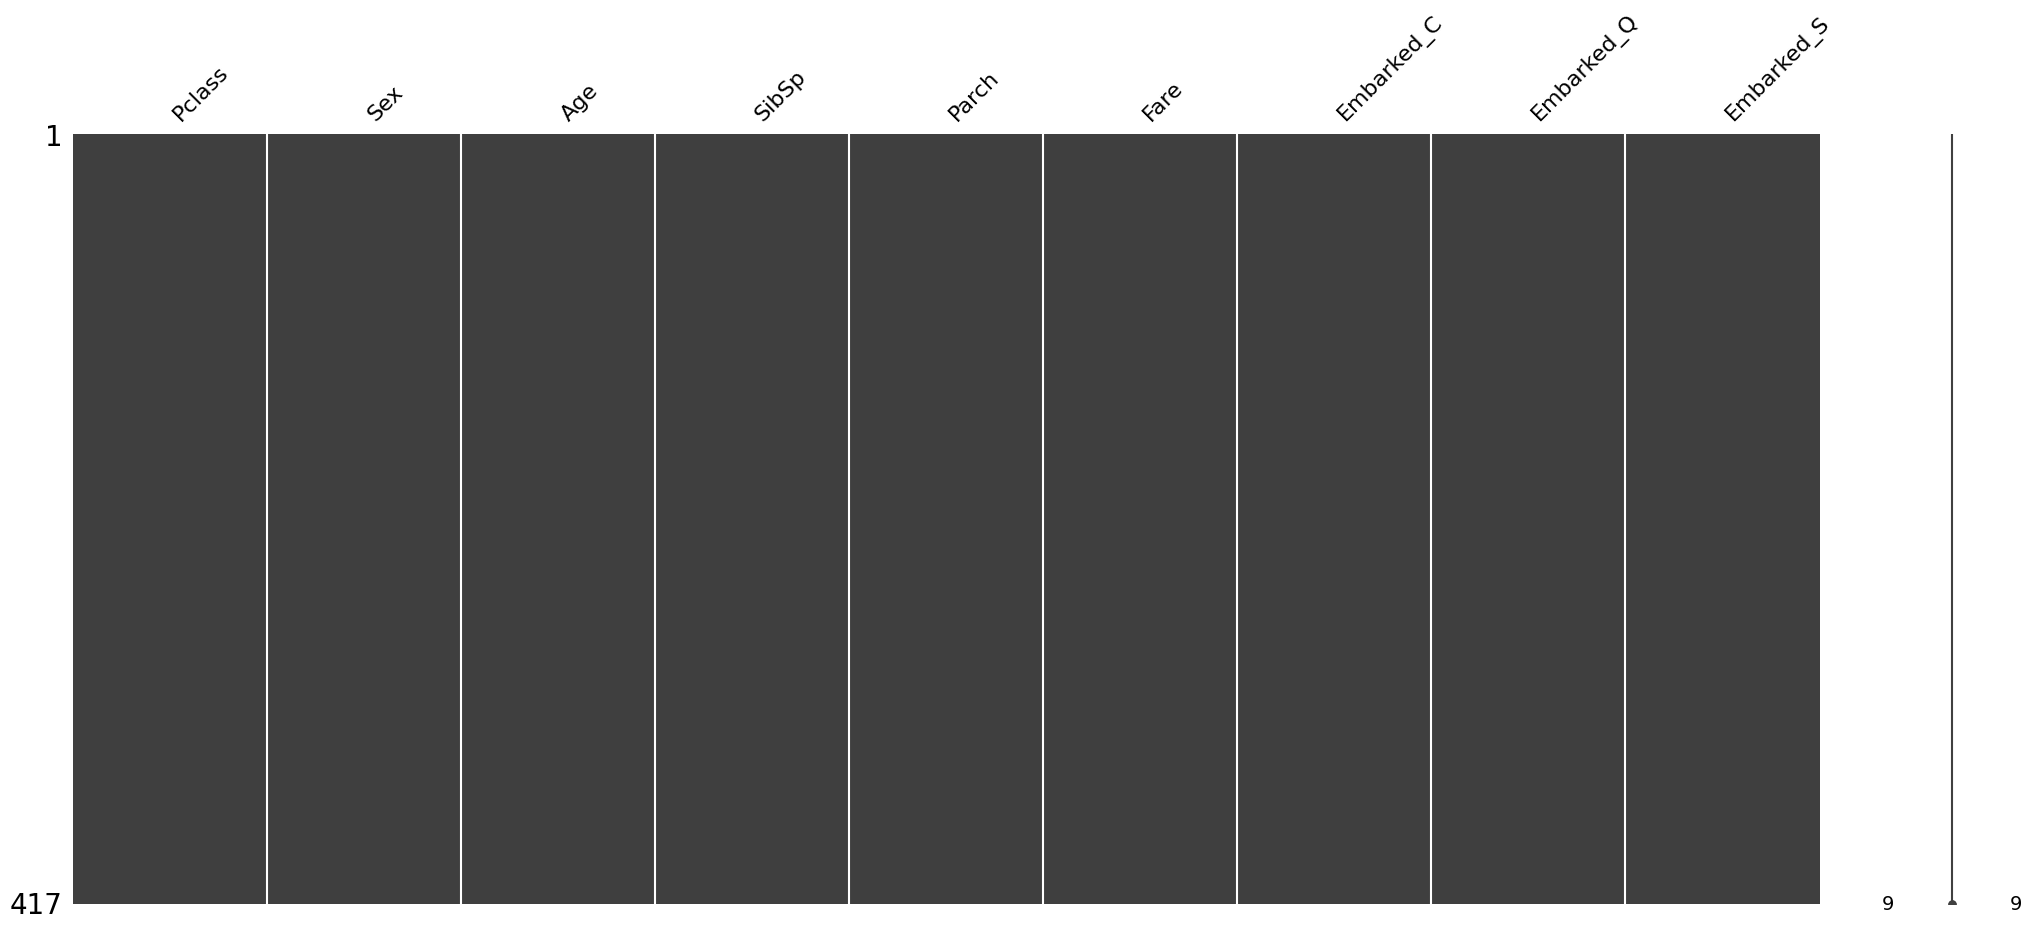

In [31]:
matrix(test_data)

# Regresja logistyczna

Regresja logistyczna jest modelem, który pozwala na przewidywanie wartości zmiennych dychotomicznych (binarnych), w oparciu o jedną lub większą ilość cech. Funkcją bazową regresji logistycznej jest funkcja logistyczna:

$$
y = \sigma(x) = \frac{1}{1 + e^{-(ax + b)}}
$$

Funkcja ta jest bardzo podobna do regresji liniowej (współczynniki, których uczy się model to $a$ oraz $b$), ale wartości tej funkcji ograniczone są do zbioru $[0,1]$. Dzięki temu można bardzo łatwo zmapować te wartości na zbiór dwuelementowy: 0 i 1, wygodny do klasyfikacji - jeśli wartość funkcji jest > 0.5, to mapowana jest ona na 1, w przeciwnym razie na 0. Bardzo ciekawe podsumowanie teoretycznych podstaw regresji logistycznej znajdziesz [tu](https://philippmuens.com/logistic-regression-from-scratch).

Zmienne dychotomiczne to inaczej zmienne, które przyjmują jedynie dwie wartości. Przykładem jest nasza kolumna **Survived** z danych trenujących. Podzielmy więc zbiór trenujący (zawierający etykiety klasy) na podzbiory do trenowania i testowania modelu.

In [89]:
X = train_data.drop(inplace=False, columns=["Survived"])
y = train_data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, shuffle=True
)

## Ocena poprawności klasyfikacji

Wytrenujmy nasz pierwszy model i oszacujmy jego dokładność.

In [90]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7488789237668162

74% - nieźle, ale może da się ten wynik poprawić. Problem, którym teraz się zajmujemy to problem klasyfikacji. W problemach klasyfikacji mamy dwie główne miary jakości modelu. Jest to dokładność (z ang. *accuracy*) albo tzw. AUC (z ang. *Area Under [ROC] Curve*).
Dokładność jest dość intuicyjną miarą, gdyż jest to liczba poprawnie zaklasyfikowanych przykładów (z obu kategorii), podzielona przez liczbę wszystkich przykładów podlegających klasyfikacji:

$$
Acc = \frac{TP+TN}{TP+TN+FP+FN},
$$

gdzie: 

* $TP$ (true positives) - liczba pozytywnych przypadków (np. osób, które przeżyły katastrofę) zaklasyfikowanych poprawnie,
* $TN$ (true negatives) - liczba negatywnych przypadków (np. osób, które nie przeżyły katastrofy) zaklasyfikowanych poprawnie,
* $FP$ (false positives) - liczba pozytywnych przypadków, zaklasyfikowanych błędnie,
* $FN$ (false negatives) - liczba negatywnych przypadków, zaklasyfikowanych błędnie.

Dokładności używamy, gdy klasy rozłożone są w miarę równomiernie, a AUC, gdy jedna klasa jest dominująca. Sprawdźmy, jak jest w naszym przypadku.

In [34]:
y_0 = y[y == 0].size
y_1 = y[y == 1].size
print("0:", y_0)
print("1:", y_1)

0: 549
1: 340


Uznajmy, że zbiór ten jest umiarkowanie zbalansowany. Wybierzmy więc `accuracy` jako `scoring`. `roc_auc` wykorzystamy w następnym laboratorium, gdzie zbiór danych będzie znacznie bardziej niezbalansowany.

**Zadanie 7 (1p.)**

Ustal optymalną liczbę cech do predykcji klasy **Survived**. Skorzystaj z `RFE`, `GridSearchCV` oraz 10-krotnej walidacji skrośnej.

In [35]:
hyper_params = [{"n_features_to_select": list(range(1, train_data.shape[1]))}]
model_rfe = RFE(model)
folds = KFold(n_splits=10, shuffle=True, random_state=0)

model_cv = GridSearchCV(
    estimator=model_rfe,
    param_grid=hyper_params,
    scoring="accuracy",
    cv=folds,
    verbose=1,
    return_train_score=True,
)

model_cv.fit(X_train, y_train)
model_cv.best_params_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


{'n_features_to_select': 7}

Posiadając liczbę cech, ustalmy jaki zestaw parametrów regresji logistycznej ([zobacz parametry](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) jest optymalny dla naszego problemu. Jako solvera użyjemy modelu *saga*. Jest on szybki i wspiera regularyzację Elastic Net ([zobacz definicję](https://en.wikipedia.org/wiki/Elastic_net_regularization)).

## Przeuczenie

W trakcie trenowania modelu może dojść do sytuacji, w której zostanie on przeuczony (z ang. *overfitting*). Gdy to się wydarzy, model może mieć bardzo dokładne wyniki, gdy zastosujemy go na danych, które już widział na etapie trenowania. Takie szacowanie jakości modelu jest oczywiście błędem metodologicznym. Przeuczenie modelu jest bardzo istotnym problemem w sztucznej inteligencji i isnieje szereg metod, służących zapobieganiu tego zjawiska. Jedną z nich jest regularyzacja - do globalnej funkcji błędu dodawane są "kary": `l1` oraz `l2`, które stanowią miary wielkości parametrów obliczonych w trakcie treningu. Obie te wartości są tak naprawdę normami (odpowiednio `l1` i `l2`) wektorów wag modelu przeskalowane przez określoną wartość (w sklearn określoną jako `C`). Dodawanie tych kar ma zabiec przeuczeniu. Jak słusznie możesz się spodziewać, zbyt duże kary spowoduję z kolei niedouczenie (ang. *underfitting*). Więcej o konstrukcji i zastosowaniach regularyzacji `l1` i `l2` przeczytać możesz [tu](https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261).

**Zadanie 8 (1p.)**
 
 Dowiedz się, jaki zestaw parametrów dla naszego problemu jest optymalny.

In [36]:
hyper_params = {
    "estimator__solver": ["saga"],
    "estimator__C": [0.001, .009, 0.01, .09, 1, 5],
    "estimator__penalty": ["l1", "l2"],
    "estimator__intercept_scaling": [0.01, 0.1, 1., 10., 20.],
    "estimator__max_iter": [1000],
    "n_features_to_select": [7]
}

model_cv = GridSearchCV(
    estimator=model_rfe,
    param_grid=hyper_params,
    scoring="accuracy",
    cv=folds,
    verbose=1,
    return_train_score=True,
)
fit = model_cv.fit(X_train, y_train)

print(model_cv.best_params_)
print(model_cv.best_score_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
{'estimator__C': 5, 'estimator__intercept_scaling': 0.01, 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'estimator__solver': 'saga', 'n_features_to_select': 7}
0.8213478064224333


**Zadanie 9 (1p.)**

Wytrenuj optymalny model (parametry dobierz na podstawie poprzednich zadań) oraz dokonaj predykcji brakujących wartości klasy **Survived** dla zbioru `titanic_test.csv`. Wyniki zwizualizuj na wykresie słupkowym.

In [37]:
model = LogisticRegression(penalty="l1", C=5, intercept_scaling=0.01, solver="saga", max_iter=1000)
model.fit(X_train, y_train)

model_rfe = RFE(model, n_features_to_select=7)
model_rfe.fit(X_train, y_train)

X_test_data = test_data.copy(deep=True)

predict = model_rfe.predict(X_test_data)
test_data["Survived"] = predict

print(test_data.head())

   Pclass  Sex       Age  SibSp     Parch      Fare  Embarked_C  Embarked_Q  \
0     1.0  1.0  0.452723  0.000  0.000000  0.015282         0.0         1.0   
1     1.0  0.0  0.617566  0.125  0.000000  0.013663         0.0         0.0   
2     0.5  1.0  0.815377  0.000  0.000000  0.018909         0.0         1.0   
3     1.0  1.0  0.353818  0.000  0.000000  0.016908         0.0         0.0   
4     1.0  0.0  0.287881  0.125  0.111111  0.023984         0.0         0.0   

   Embarked_S  Survived  
0         0.0       0.0  
1         1.0       0.0  
2         0.0       0.0  
3         1.0       0.0  
4         1.0       1.0  


<AxesSubplot: ylabel='Frequency'>

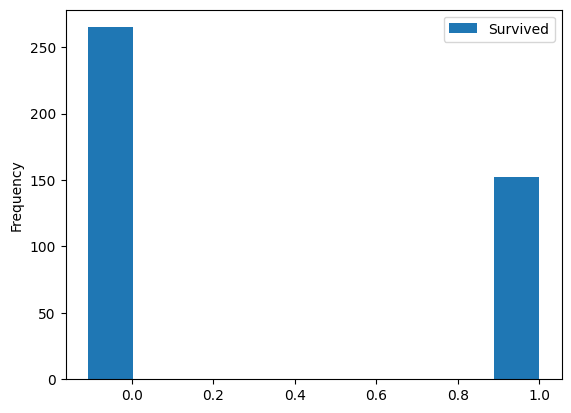

In [38]:
test_data.plot.hist(column=["Survived"])

# Pytania kontrolne

(**1p.**)

1. Co zrobić z kolumną, która zawiera wartości od "A" do "D", a powinna zostać wykorzystana przez model?

Tworzymy 4 nowe kolumny: kolumna_A, kolumna_B, kolumna_C, kolumna_D zawierające wartości 1 lub 0, przy czym 1 występuje tylko w jednej kolumnie dla danego wiersza. Jedynka w kolumna_A oznacza że dany wiersz miał wartość A. 

2. Jakie są sposoby radzenia sobie z danymi brakującymi?


- Usunąć kolumnę, która zawiera brakujące wartości
- Usunąć wiersze, w których brakuje wartości
- Zastąpić brakujące wartości innymi, np. średnią
- Przewidzieć brakujące wartości wykorzystując odpowiedni model uczenia maszynowego

3. Jak nazwiesz typ wartości dla kolumny, która zawiera tylko i wyłącznie liczby 13 oraz 17?

Dane kategoryczne.

4. Czy stosowanie jednorazowego podziału zbioru na testowy i trenujący jest zawsze niezalecane? Jaka jest inna metoda?

Nie jest ponieważ może dawać błędne wyniki w szczególności, jeśli zbiór danych jest mały. Możemy użyć walidacji skrośnej, która polega na tym, że całość zbioru trenującego dzielimy na K równych podzbiorów. Każdy podzbiór raz jest zbiorem testowym, a reszta staje się zbiorem trenującym. Otrzymujemy K osobnych wników, które uśredniamy. 

5. Czy każda cecha w modelu jest istotna? Jakie znasz metody wybierania podzbiorów cech?

Nie każdna. Macierz korelacji, wyszukiwanie ilości cech *n_features_to_select* przy użyciu szukania hiperparametrów na siatce (GridSearchCV + RFE).

6. Jak oszacować skuteczność modelu, który dokonuje predykcji gatunku zwierzęcia, a jak modelu, który przewiduje kurs akcji giełdowych?

Dla modelu, który dokonuje predykcji gatunku zwierzęcia możemy użyć współczynnika dokładność, ponieważ jest to problem klasyfikacji. Natomiast dla modelu, który dokonuje predykcji kursu aukcji giełdowych - MSE, ponieważ jest to problem regresji (ciągły).



7. Jakiej wartości korelacji spodziewać się dla danych typu kraj pochodzenia - język, a jakich dla problemu typu *predator - prey*?

Dla typu kraj pochodzenia - język możemy spodziewać się dużej korelacji między cechami.

8. Jakich modeli użyć dla obu problemów opisanych w punkcie wyżej?

# Zadanie dodatkowe *

**(2p.)**

Poniższe zadanie jest dodatkowe, nie musisz go wykonać.

W tym laboratorium rozważyliśmy dwa rodzaje regresji: liniową i logistyczną. W bibliotece sklearn istnieje jednak kilka innych typów liniowych modeli ([Linear classifiers](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn+linear_model#module-sklearn.linear_model)). Sprawdź czy dla problemu wieku (**Age**) i/lub klasy **Survived** dasz radę uzyskać wyższą skuteczność niż dla modeli zaproponowanych w laboratorium. Jeżeli Ci się to uda, oszacuj, czy różnica/różnice są znaczące z punktu widzenia statystycznego.

Dodatkowo, jeżeli wyżej wspomniane tematy są dla Ciebie interesujące, zapoznaj się z materiałami dodatkowymi: [train-valid-test split](https://mlu-explain.github.io/train-test-validation/), [ROC & AUC](https://mlu-explain.github.io/roc-auc/), [Regresja logistyczna](https://mlu-explain.github.io/logistic-regression/), [MLU Explain](https://mlu-explain.github.io/linear-regression/) oraz [regularyzacja L1 i L2](https://sebastianraschka.com/faq/docs/regularization-linear.html).

In [94]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier

X = train_data.drop(inplace=False, columns=["Survived"])
y = train_data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, shuffle=True
)

model = RidgeClassifier()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

model2 = LogisticRegression()
model2.fit(X_train, y_train)
print(model2.score(X_test, y_test))

hyper_params = {
    "estimator__solver": ["saga"],
    "estimator__C": [0.001, .009, 0.01, .09, 1, 5],
    "estimator__penalty": ["l1", "l2"],
    "estimator__intercept_scaling": [0.01, 0.1, 1., 10., 20.],
    "estimator__max_iter": [1000],
    "n_features_to_select": [8]
}

model_

model_cv = GridSearchCV(
    estimator=model_rfe,
    param_grid=hyper_params,
    scoring="accuracy",
    cv=folds,
    verbose=1,
    return_train_score=True,
)
fit = model_cv.fit(X_train, y_train)

print(model_cv.best_params_)
print(model_cv.best_score_)


0.757847533632287
0.7488789237668162
Fitting 10 folds for each of 60 candidates, totalling 600 fits


ValueError: Invalid parameter 'C' for estimator RidgeClassifier(). Valid parameters are: ['alpha', 'class_weight', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'].